# Sarcasm Detection using Machine Learning

#### Goal of This File:

##### 1. Import Libraries, Helper Functions, and Constants ==> Data Sourcing and Munging ==> Utility Functions ==> Loading the Data ==> Merging all Individual Files

##### 2. Word Embeddings 

##### 3. Machine Learning Models ==> Small Model Test

##### 4. Conclusion ==> Results

## 1. Import Libraries, Helper Functions and Load Constants

In [1]:
!pip install pandas numpy nltk scikit-learn wordcloud\
seaborn gensim tensorflow imblearn xgboost matplotlib unrar pyunpack more-itertools patool keras-tqdm > /dev/null

The system cannot find the path specified.


In [2]:
VAST = False

if VAST:
    !sudo apt-get install unrar
    !sudo apt-get install rar

GDRIVE = False

In [3]:
UTILS_URL = 'https://f005.backblazeb2.com/file/gp-support-files/archived_nlp_ai_utils.py'
UPDATING_VALUES_URL = 'https://f005.backblazeb2.com/file/gp-support-files/archived_updating_values.py'
ALL_LIBS_URL = 'https://f005.backblazeb2.com/file/gp-support-files/archived_all_libs_dl.py'
CHUNKS_URLS_FILE_URL = 'https://f005.backblazeb2.com/file/gp-support-files/chunks_urls.py'

UTILS_FILE_NAME = 'archived_nlp_ai_utils'
UPDATING_VALUES_FILE_NAME = 'archived_updating_values'
ALL_LIBS_FILE_NAME = 'archived_all_libs_dl'
CHUNKS_URLS_FILE_NAME = 'chunks_urls'

DEP_FILE_EXT = '.py'

In [4]:
import requests
import os

def get_dependencies(url,file_name,file_extension):
    if os.path.exists(file_name + file_extension):
        return print(file_name + " already exists.")
    else:
        print(f"downloading {file_name}...")
        r = requests.get(url)
        with open(file_name + file_extension, 'wb') as fd:
            for chunk in r.iter_content():
                fd.write(chunk)

In [5]:
get_dependencies(UTILS_URL,UTILS_FILE_NAME,DEP_FILE_EXT)
get_dependencies(UPDATING_VALUES_URL,UPDATING_VALUES_FILE_NAME,DEP_FILE_EXT)
get_dependencies(ALL_LIBS_URL,ALL_LIBS_FILE_NAME,DEP_FILE_EXT)
get_dependencies(CHUNKS_URLS_FILE_URL,CHUNKS_URLS_FILE_NAME,DEP_FILE_EXT)

archived_nlp_ai_utils already exists.
archived_updating_values already exists.
archived_all_libs_dl already exists.
chunks_urls already exists.


In [6]:
from archived_nlp_ai_utils import *
from chunks_urls import SD_CHUNKS_URLS
from archived_updating_values import *

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already u

In [7]:
TF_ENABLE_ONEDNN_OPTS = 0
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
DATA_URLS = SD_CHUNKS_URLS
LIMIT = SD_DATA_LIMIT
TRAINED_MODELS_COUNT = TRAINED_MODELS
if GDRIVE:
    DATASET_PATH = "datasets"
    PICKLES_DIR = "sd_pickle_files"
else:
    DATASET_PATH = "../datasets"
    PICKLES_DIR = "../sd_pickle_files"

PREPROCESSED_CHUNKS_PATH = DATASET_PATH + "/preprocessed_sd_data_chunks/"
BASE_FILE_NAME = "sd_chunk_"
FILE_FORMAT = ".csv"
DATA_IN_CHUNK = 99744
if LIMIT == 10:
    ACTUAL_DATA_SHAPE = DATA_IN_CHUNK * LIMIT - 2
else:
    ACTUAL_DATA_SHAPE = DATA_IN_CHUNK * LIMIT
RANDOM_STATE = CONST_RANDOM_STATE
np.random.seed(CONST_RANDOM_STATE)

USE_SUBSET = 10000
PRINT_METRICS = True

### 1.1 Data Sourcing and Munging

#### 1.1.1 Loading The Data

In [8]:
DATASET_PATH

'../datasets'

In [9]:
PREPROCESSED_CHUNKS_PATH

'../datasets/preprocessed_sd_data_chunks/'

In [10]:
if not os.path.exists(DATASET_PATH):
    os.mkdir(DATASET_PATH)
if not os.path.exists(PREPROCESSED_CHUNKS_PATH):
    os.mkdir(PREPROCESSED_CHUNKS_PATH)
get_chunks(DATA_URLS,LIMIT,1,BASE_FILE_NAME,PREPROCESSED_CHUNKS_PATH,FILE_FORMAT)

sd_chunk_1 already exists.


#### 1.1.2 Merging all Individual Files

In [11]:
#get all names of downloaded files
all_file_names = get_all_file_names(BASE_FILE_NAME,LIMIT)

In [12]:
#read all chunks into a list
list_dfs = read_chunks(all_file_names,PREPROCESSED_CHUNKS_PATH,FILE_FORMAT)

In [13]:
#concatenate all chunks into a singular df
df = group_up_chunks(list_dfs)

In [14]:
if USE_SUBSET:
    df = df[:USE_SUBSET]
    ACTUAL_DATA_SHAPE = USE_SUBSET

In [15]:
#check how much of the data was actually downloaded
percent_loaded = check_no_missing_data(df.shape[0],ACTUAL_DATA_SHAPE)
percent_loaded

100.0

In [16]:
df.reset_index(inplace = True)
df.drop(['index'],axis = 1,inplace = True)

In [17]:
X = df['text']
y = df['labels']

In [18]:
X = pd.Series([str(text) for text in X])

y = pd.Series([int(label) for label in y])

In [19]:
if not os.path.exists(PICKLES_DIR):
    os.mkdir(PICKLES_DIR)

## 2. Word Embeddings

In [20]:
TRAIN_PERCENT = 0.8
VALID_TEST_PERCENT = 0.1
TRAIN_SIZE = int(ACTUAL_DATA_SHAPE * TRAIN_PERCENT)
VALID_TEST_SIZE = int(ACTUAL_DATA_SHAPE * VALID_TEST_PERCENT)
TOTAL_TEST_SIZE = TRAIN_SIZE + VALID_TEST_SIZE

### 2.1 Word2Vec

In [21]:
text_tokens = [nltk.word_tokenize(text) for text in X]

In [22]:
w2v_tokens = text_tokens

In [23]:
w2v_model = Word2Vec(sentences = w2v_tokens, vector_size = 100, window = 5, min_count=1, workers = 4)

In [24]:
X_W2V = np.zeros((len(w2v_tokens), w2v_model.vector_size))
for i, text in enumerate(w2v_tokens):
    for word in text:
        if word in w2v_model.wv:
            X_W2V[i] += w2v_model.wv[word]
    X_W2V[i] /= len(w2v_tokens)

### 2.2 TF-IDF

In [25]:
tfidf_text = X

In [26]:
tfidf_model = TfidfVectorizer()

train_set_tfidf = tfidf_model.fit_transform(tfidf_text[:TRAIN_SIZE]).toarray()

validation_set_tfidf = tfidf_model.transform(tfidf_text[TRAIN_SIZE:TOTAL_TEST_SIZE]).toarray()

test_set_tfidf = tfidf_model.transform(tfidf_text[TOTAL_TEST_SIZE:]).toarray()

### 2.3 FastText

In [27]:
fasttext_tokens = text_tokens

In [28]:
ft_model = FastText(sentences = fasttext_tokens, vector_size = 100, window = 5, min_count = 1, workers = 4)

In [29]:
X_FT = np.zeros((len(fasttext_tokens), ft_model.vector_size))
for i, text in enumerate(fasttext_tokens):
    for word in text:
        if word in ft_model.wv:
            X_FT[i] += ft_model.wv[word]
    X_FT[i] /= len(fasttext_tokens)

## 3. Machine Learning Models

In [30]:
X_W2V = preprocessing.normalize(X_W2V)
train_set_tfidf = preprocessing.normalize(train_set_tfidf)
validation_set_tfidf = preprocessing.normalize(validation_set_tfidf)
test_set_tfidf = preprocessing.normalize(test_set_tfidf)
X_FT = preprocessing.normalize(X_FT)

In [31]:
sc = StandardScaler()
train_set_tfidf = sc.fit_transform(train_set_tfidf)
validation_set_tfidf = sc.transform(validation_set_tfidf)
test_set_tfidf = sc.transform(test_set_tfidf)

### 3.1 Word2Vec Train-Validation-Test Split

In [32]:
train_set_w2v = X_W2V[:TRAIN_SIZE]
train_labels_w2v = y[:TRAIN_SIZE]
validation_set_w2v = X_W2V[TRAIN_SIZE:TOTAL_TEST_SIZE]
validation_labels_w2v = y[TRAIN_SIZE:TOTAL_TEST_SIZE]
test_set_w2v = X_W2V[TOTAL_TEST_SIZE:]
test_labels_w2v = y[TOTAL_TEST_SIZE:]

### 3.2 TF-IDF Train-Validation-Test Split

In [33]:
train_labels_tfidf = y[:TRAIN_SIZE]
validation_labels_tfidf = y[TRAIN_SIZE:TOTAL_TEST_SIZE]
test_labels_tfidf = y[TOTAL_TEST_SIZE:]

### 3.3 FastText Train-Validation-Test Split

In [34]:
train_set_ft = X_FT[:TRAIN_SIZE]
train_labels_ft = y[:TRAIN_SIZE]
validation_set_ft = X_FT[TRAIN_SIZE:TOTAL_TEST_SIZE]
validation_labels_ft = y[TRAIN_SIZE:TOTAL_TEST_SIZE]
test_set_ft = X_FT[TOTAL_TEST_SIZE:]
test_labels_ft = y[TOTAL_TEST_SIZE:]

### 3.4 Naive Bayes

#### 3.4.1 Word2Vec 

In [35]:
if not os.path.exists(PICKLES_DIR + '/' + 'all_nb' + '.pickle'):
    nb_clf_w2v = GaussianNB()
    nb_clf_w2v.fit(train_set_w2v, train_labels_w2v)
    validation_predictions_nb_w2v = nb_clf_w2v.predict(validation_set_w2v)
    nb_w2v_accuracy = metrics.accuracy_score(validation_labels_w2v,validation_predictions_nb_w2v)
else:
    print("Found Pickle File.")

Found Pickle File.


#### 3.4.2 TF-IDF 

In [36]:
if not os.path.exists(PICKLES_DIR + '/' + 'all_nb' + '.pickle'):
    nb_clf_tfidf = GaussianNB()
    nb_clf_tfidf.fit(train_set_tfidf, train_labels_tfidf)
    validation_predictions_nb_tfidf = nb_clf_tfidf.predict(validation_set_tfidf)
    nb_tfidf_accuracy = metrics.accuracy_score(validation_labels_tfidf,validation_predictions_nb_tfidf)
else:
    print("Found Pickle File.")

Found Pickle File.


#### 3.4.3 FastText

In [37]:
if not os.path.exists(PICKLES_DIR + '/' + 'all_nb' + '.pickle'):
    nb_clf_ft = GaussianNB()
    nb_clf_ft.fit(train_set_ft, train_labels_ft)
    validation_predictions_nb_ft = nb_clf_ft.predict(validation_set_ft)
    nb_ft_accuracy = metrics.accuracy_score(validation_labels_ft,validation_predictions_nb_ft)
else:
    print("Found Pickle File.")

Found Pickle File.


### 3.5 lr

#### 3.5.1 Word2Vec 

In [38]:
if not os.path.exists(PICKLES_DIR + '/' + 'all_lr' + '.pickle'):
    lr_clf_w2v = LogisticRegression(random_state=RANDOM_STATE)
    lr_clf_w2v.fit(train_set_w2v, train_labels_w2v)
    validation_predictions_lr_w2v = lr_clf_w2v.predict(validation_set_w2v)
    lr_w2v_accuracy = metrics.accuracy_score(validation_labels_w2v,validation_predictions_lr_w2v)
else:
    print("Found Pickle File.")

Found Pickle File.


#### 3.5.2 TF-IDF 

In [39]:
if not os.path.exists(PICKLES_DIR + '/' + 'all_lr' + '.pickle'):
    lr_clf_tfidf = LogisticRegression(random_state=RANDOM_STATE)
    lr_clf_tfidf.fit(train_set_tfidf, train_labels_tfidf)
    validation_predictions_lr_tfidf = lr_clf_tfidf.predict(validation_set_tfidf)
    lr_tfidf_accuracy = metrics.accuracy_score(validation_labels_tfidf,validation_predictions_lr_tfidf)
else:
    print("Found Pickle File.")

Found Pickle File.


#### 3.5.3 FastText

In [40]:
if not os.path.exists(PICKLES_DIR + '/' + 'all_lr' + '.pickle'):
    lr_clf_ft = LogisticRegression(random_state=RANDOM_STATE)
    lr_clf_ft.fit(train_set_ft, train_labels_ft)
    validation_predictions_lr_ft = lr_clf_ft.predict(validation_set_ft)
    lr_ft_accuracy = metrics.accuracy_score(validation_labels_ft,validation_predictions_lr_ft)
else:
    print("Found Pickle File.")

Found Pickle File.


### 3.6 Random Forest

#### 3.6.1 Word2Vec

In [41]:
if not os.path.exists(PICKLES_DIR + '/' + 'all_rf' + '.pickle'):
    rf_clf_w2v = RandomForestClassifier(n_estimators=50,random_state=RANDOM_STATE)
    rf_clf_w2v.fit(train_set_w2v, train_labels_w2v)
    validation_predictions_rf_w2v = rf_clf_w2v.predict(validation_set_w2v)
    rf_w2v_accuracy = metrics.accuracy_score(validation_labels_w2v,validation_predictions_rf_w2v)
else:
    print("Found Pickle File.")

Found Pickle File.


#### 3.6.2 TF-IDF

In [42]:
if not os.path.exists(PICKLES_DIR + '/' + 'all_rf' + '.pickle'):
    rf_clf_tfidf = RandomForestClassifier(n_estimators=50,random_state=RANDOM_STATE)
    rf_clf_tfidf.fit(train_set_tfidf, train_labels_tfidf)
    validation_predictions_rf_tfidf = rf_clf_tfidf.predict(validation_set_tfidf)
    rf_tfidf_accuracy = metrics.accuracy_score(validation_labels_tfidf,validation_predictions_rf_tfidf)
else:
    print("Found Pickle File.")

Found Pickle File.


#### 3.6.3 FastText

In [43]:
if not os.path.exists(PICKLES_DIR + '/' + 'all_rf' + '.pickle'):
    rf_clf_ft = RandomForestClassifier(n_estimators=50,random_state=RANDOM_STATE)
    rf_clf_ft.fit(train_set_ft, train_labels_ft)
    validation_predictions_rf_ft = rf_clf_ft.predict(validation_set_ft)
    rf_ft_accuracy = metrics.accuracy_score(validation_labels_ft,validation_predictions_rf_ft)
else:
    print("Found Pickle File.")

Found Pickle File.


### 3.7 XGBoost

#### 3.7.1 Word2Vec

In [44]:
if not os.path.exists(PICKLES_DIR + '/' + 'all_xgb' + '.pickle'):
    xgb_clf_w2v = XGBClassifier(random_state=RANDOM_STATE)
    xgb_clf_w2v.fit(train_set_w2v, train_labels_w2v)
    validation_predictions_xgb_w2v = xgb_clf_w2v.predict(validation_set_w2v)
    xgb_w2v_accuracy = metrics.accuracy_score(validation_labels_w2v,validation_predictions_xgb_w2v)
else:
    print("Found Pickle File.")

#### 3.7.2 TF-IDF

In [45]:
if not os.path.exists(PICKLES_DIR + '/' + 'all_xgb' + '.pickle'):
    xgb_clf_tfidf = XGBClassifier(random_state=RANDOM_STATE)
    xgb_clf_tfidf.fit(train_set_tfidf, train_labels_tfidf)
    validation_predictions_xgb_tfidf = xgb_clf_tfidf.predict(validation_set_tfidf)
    xgb_tfidf_accuracy = metrics.accuracy_score(validation_labels_tfidf,validation_predictions_xgb_tfidf)
else:
    print("Found Pickle File.")

#### 3.7.3 FastText

In [46]:
if not os.path.exists(PICKLES_DIR + '/' + 'all_xgb' + '.pickle'):
    xgb_clf_ft = XGBClassifier(random_state=RANDOM_STATE)
    xgb_clf_ft.fit(train_set_ft, train_labels_ft)
    validation_predictions_xgb_ft = xgb_clf_ft.predict(validation_set_ft)
    xgb_ft_accuracy = metrics.accuracy_score(validation_labels_ft,validation_predictions_xgb_ft)
else:
    print("Found Pickle File.")

### 3.8 Small Model Test

In [47]:
def test_model(sentence,embedding,clf):
    test_token = nltk.word_tokenize(sentence)
    test_vector = np.zeros(embedding.vector_size)
    for word in test_token:
        if word in embedding.wv:
            test_vector += embedding.wv[word]
    test_vector /= len(test_token)
    predicted_label = clf.predict([test_vector])[0]
    return predicted_label

#### 3.9 Save Models

In [48]:
all_models = []

In [49]:
if os.path.exists(PICKLES_DIR + '/' + "all_nb.pickle"):
    print("Found Pickle File for nb.")
    all_nb = pickle.load(open(PICKLES_DIR + '/' + 'all_nb.pickle','rb'))
else:
    pickle_out = open(PICKLES_DIR + '/' + 'all_nb' + '.pickle','wb')
    nb_dict = {'nb_clf_w2v':nb_clf_w2v,'nb_clf_w2v_preds':validation_predictions_nb_w2v,'nb_clf_tfidf':nb_clf_tfidf,\
        'nb_clf_tfidf_preds':validation_predictions_nb_tfidf,'nb_clf_ft':nb_clf_ft,'nb_clf_ft_preds':validation_predictions_nb_ft,}
    pickle.dump(nb_dict,pickle_out)
    pickle_out.close()
    all_nb = nb_dict
    print("Created Pickle File for nb.")
    
all_models.append(all_nb)

Found Pickle File for nb.


In [50]:
if os.path.exists(PICKLES_DIR + '/' + "all_lr.pickle"):
    print("Found Pickle File for lr.")
    all_lr = pickle.load(open(PICKLES_DIR + '/' + 'all_lr.pickle','rb'))
else:
    pickle_out = open(PICKLES_DIR + '/' + 'all_lr' + '.pickle','wb')
    lr_dict = {'lr_clf_w2v':lr_clf_w2v,'lr_clf_w2v_preds':validation_predictions_lr_w2v,'lr_clf_tfidf':lr_clf_tfidf,\
        'lr_clf_tfidf_preds':validation_predictions_lr_tfidf,'lr_clf_ft':lr_clf_ft,'lr_clf_ft_preds':validation_predictions_lr_ft}
    pickle.dump(lr_dict,pickle_out)
    pickle_out.close()
    all_lr = lr_dict
    print("Created Pickle File for lr.")

all_models.append(all_lr)

Found Pickle File for lr.


In [51]:
if os.path.exists(PICKLES_DIR + '/' + "all_rf.pickle"):
    print("Found Pickle File for rf.")
    all_rf = pickle.load(open(PICKLES_DIR + '/' + 'all_rf.pickle','rb'))
else:
    pickle_out = open(PICKLES_DIR + '/' + 'all_rf' + '.pickle','wb')
    rf_dict = {'rf_clf_w2v':rf_clf_w2v,'rf_clf_w2v_preds':validation_predictions_rf_w2v,'rf_clf_tfidf':rf_clf_tfidf,\
        'rf_clf_tfidf_preds':validation_predictions_rf_tfidf,'rf_clf_ft':rf_clf_ft,'rf_clf_ft_preds':validation_predictions_rf_ft}
    pickle.dump(rf_dict,pickle_out)
    pickle_out.close()
    all_rf = rf_dict
    print("Created Pickle File for rf.")
    
all_models.append(all_rf)

Found Pickle File for rf.


In [52]:
if os.path.exists(PICKLES_DIR + "/" + "all_xgb.pickle"):
    print("Found Pickle File for xgb.")
    all_xgb = pickle.load(open(PICKLES_DIR + '/' + 'all_xgb.pickle','rb'))
else:
    pickle_out = open(PICKLES_DIR + '/' + 'all_xgb' + '.pickle','wb')
    xgb_dict = {'xgb_clf_w2v':xgb_clf_w2v,'xgb_clf_w2v_preds':validation_predictions_xgb_w2v,'xgb_clf_tfidf':xgb_clf_tfidf,\
        'xgb_clf_tfidf_preds':validation_predictions_xgb_tfidf,'xgb_clf_ft':xgb_clf_ft,'xgb_clf_ft_preds':validation_predictions_xgb_ft,}
    pickle.dump(xgb_dict,pickle_out)
    pickle_out.close()
    all_xgb = xgb_dict
    print("Created Pickle File for xgb.")
    
all_models.append(all_xgb)

Created Pickle File for xgb.


## 4. Conclusion

### 4.1 Results

PRINTING METRICS FOR Gaussian Naive Bayes/Word2Vec


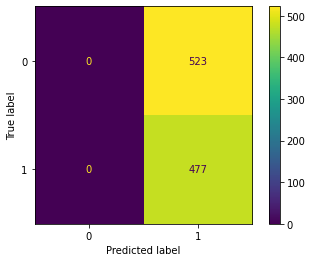

ROC/AUC for each class: 

{0: 0.5805544532230199, 1: 0.5805544532230199}


Classification Report = 
                precision    recall  f1-score   support

           0       0.66      0.37      0.48       523
           1       0.53      0.79      0.64       477

    accuracy                           0.57      1000
   macro avg       0.60      0.58      0.56      1000
weighted avg       0.60      0.57      0.55      1000



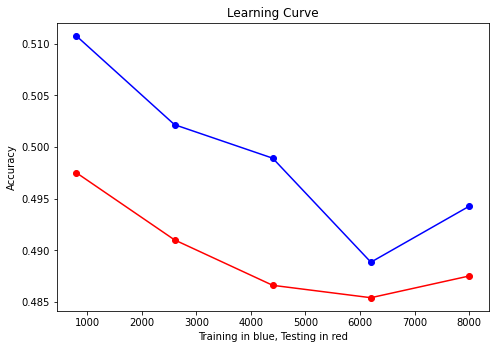

PRINTING METRICS FOR Gaussian Naive Bayes/TFIDF


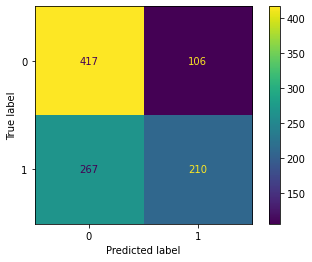

ROC/AUC for each class: 

{0: 0.618787354041151, 1: 0.6187873540411511}


Classification Report = 
                precision    recall  f1-score   support

           0       0.61      0.80      0.69       523
           1       0.66      0.44      0.53       477

    accuracy                           0.63      1000
   macro avg       0.64      0.62      0.61      1000
weighted avg       0.64      0.63      0.61      1000



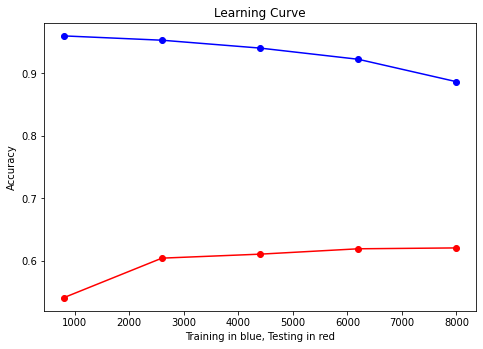

PRINTING METRICS FOR Gaussian Naive Bayes/FastText


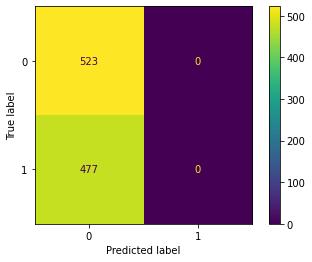

ROC/AUC for each class: 

{0: 0.5626465601212165, 1: 0.5626465601212165}


Classification Report = 
                precision    recall  f1-score   support

           0       0.74      0.20      0.32       523
           1       0.51      0.92      0.66       477

    accuracy                           0.55      1000
   macro avg       0.63      0.56      0.49      1000
weighted avg       0.63      0.55      0.48      1000



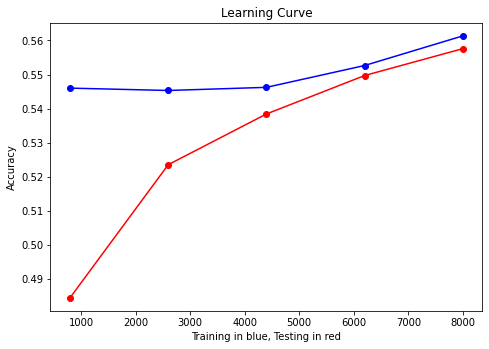

In [53]:
show_metrics('Gaussian Naive Bayes/Word2Vec',all_models[0]['nb_clf_w2v'],validation_set_w2v,validation_labels_w2v,all_models[0]['nb_clf_w2v_preds'],X_W2V,y,5)
show_metrics('Gaussian Naive Bayes/TFIDF',all_models[0]['nb_clf_tfidf'],validation_set_tfidf,validation_labels_tfidf,all_models[0]['nb_clf_tfidf_preds'],\
             np.concatenate([train_set_tfidf,validation_set_tfidf,test_set_tfidf]),y,5)
show_metrics('Gaussian Naive Bayes/FastText',all_models[0]['nb_clf_ft'],validation_set_ft,validation_labels_ft,all_models[0]['nb_clf_ft_preds'],X_FT,y,5)

PRINTING METRICS FOR Logistic Regression/Word2Vec


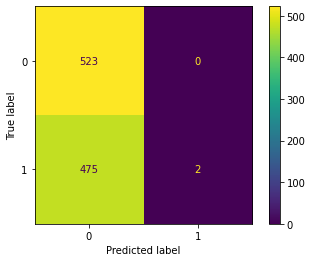

ROC/AUC for each class: 

{0: 0.5020964360587001, 1: 0.5020964360587002}


Classification Report = 
                precision    recall  f1-score   support

           0       0.52      1.00      0.69       523
           1       1.00      0.00      0.01       477

    accuracy                           0.53      1000
   macro avg       0.76      0.50      0.35      1000
weighted avg       0.75      0.53      0.36      1000



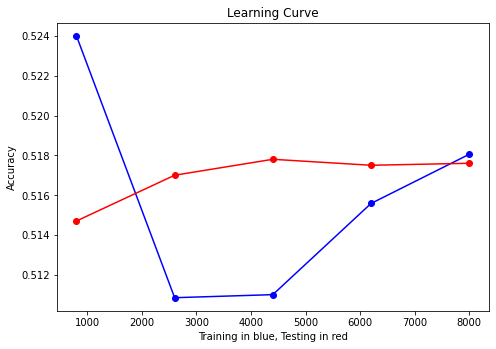

PRINTING METRICS FOR Logistic Regression/TFIDF


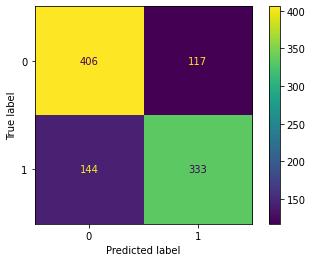

ROC/AUC for each class: 

{0: 0.7372019192611566, 1: 0.7372019192611566}


Classification Report = 
                precision    recall  f1-score   support

           0       0.74      0.78      0.76       523
           1       0.74      0.70      0.72       477

    accuracy                           0.74      1000
   macro avg       0.74      0.74      0.74      1000
weighted avg       0.74      0.74      0.74      1000



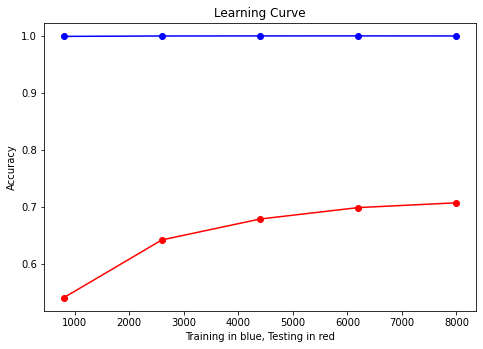

PRINTING METRICS FOR Logistic Regression/FastText


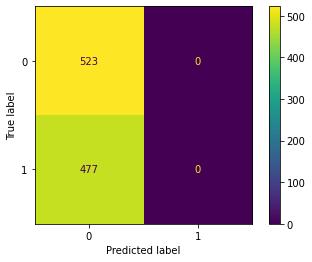

ROC/AUC for each class: 

{0: 0.5, 1: 0.5}


Classification Report = 
                precision    recall  f1-score   support

           0       0.52      1.00      0.69       523
           1       0.00      0.00      0.00       477

    accuracy                           0.52      1000
   macro avg       0.26      0.50      0.34      1000
weighted avg       0.27      0.52      0.36      1000



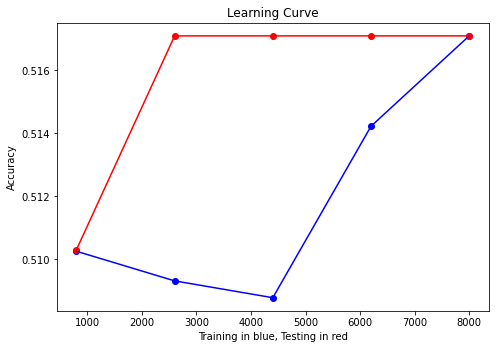

In [54]:
if PRINT_METRICS:
    show_metrics('Logistic Regression/Word2Vec',all_models[1]['lr_clf_w2v'],validation_set_w2v,validation_labels_w2v,all_models[1]['lr_clf_w2v_preds'],X_W2V,y,5)
    show_metrics('Logistic Regression/TFIDF',all_models[1]['lr_clf_tfidf'],validation_set_tfidf,validation_labels_tfidf,all_models[1]['lr_clf_tfidf_preds'],\
                np.concatenate([train_set_tfidf,validation_set_tfidf,test_set_tfidf]),y,5)
    show_metrics('Logistic Regression/FastText',all_models[1]['lr_clf_ft'],validation_set_ft,validation_labels_ft,all_models[1]['lr_clf_ft_preds'],X_FT,y,5)

PRINTING METRICS FOR Random Forest/Word2Vec


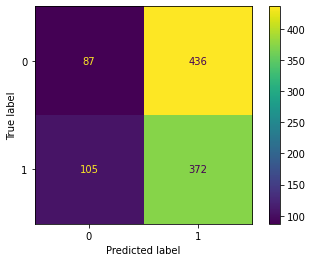

ROC/AUC for each class: 

{0: 0.6976361981953814, 1: 0.6976361981953814}


Classification Report = 
                precision    recall  f1-score   support

           0       0.71      0.71      0.71       523
           1       0.68      0.69      0.69       477

    accuracy                           0.70      1000
   macro avg       0.70      0.70      0.70      1000
weighted avg       0.70      0.70      0.70      1000



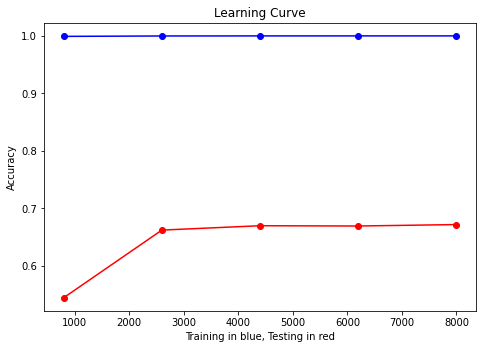

PRINTING METRICS FOR Random Forest/TFIDF


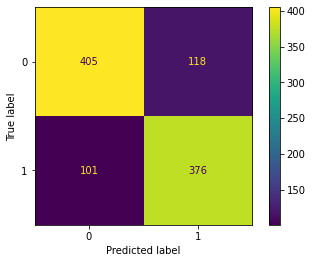

ROC/AUC for each class: 

{0: 0.7813192715786604, 1: 0.7813192715786604}


Classification Report = 
                precision    recall  f1-score   support

           0       0.80      0.77      0.79       523
           1       0.76      0.79      0.77       477

    accuracy                           0.78      1000
   macro avg       0.78      0.78      0.78      1000
weighted avg       0.78      0.78      0.78      1000



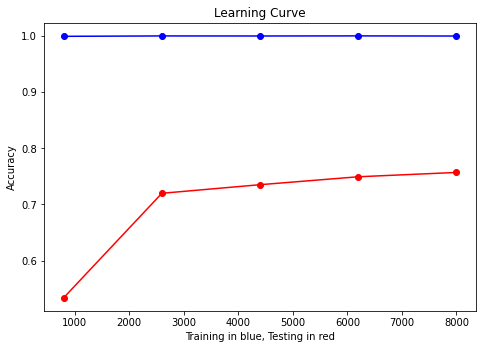

PRINTING METRICS FOR Random Forest/FastText


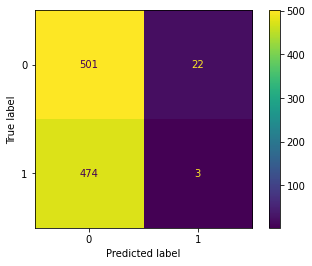

ROC/AUC for each class: 

{0: 0.716814780074638, 1: 0.716814780074638}


Classification Report = 
                precision    recall  f1-score   support

           0       0.73      0.72      0.73       523
           1       0.70      0.71      0.71       477

    accuracy                           0.72      1000
   macro avg       0.72      0.72      0.72      1000
weighted avg       0.72      0.72      0.72      1000



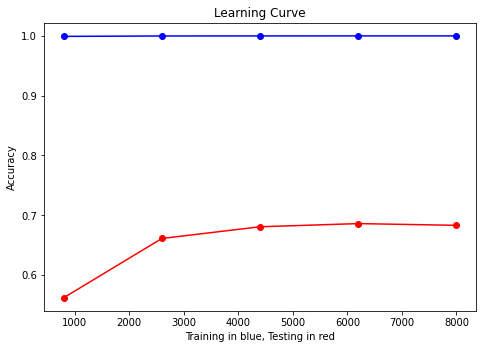

In [55]:
if PRINT_METRICS:
    show_metrics('Random Forest/Word2Vec',all_models[2]['rf_clf_w2v'],validation_set_w2v,validation_labels_w2v,all_models[2]['rf_clf_w2v_preds'],X_W2V,y,5)
    show_metrics('Random Forest/TFIDF',all_models[2]['rf_clf_tfidf'],validation_set_tfidf,validation_labels_tfidf,all_models[2]['rf_clf_tfidf_preds'],\
                np.concatenate([train_set_tfidf,validation_set_tfidf,test_set_tfidf]),y,5)
    show_metrics('Random Forest/FastText',all_models[2]['rf_clf_ft'],validation_set_ft,validation_labels_ft,all_models[2]['rf_clf_ft_preds'],X_FT,y,5)

PRINTING METRICS FOR XGBoost/Word2Vec


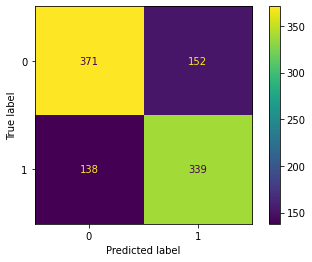

ROC/AUC for each class: 

{0: 0.7100304243779838, 1: 0.7100304243779838}


Classification Report = 
                precision    recall  f1-score   support

           0       0.73      0.71      0.72       523
           1       0.69      0.71      0.70       477

    accuracy                           0.71      1000
   macro avg       0.71      0.71      0.71      1000
weighted avg       0.71      0.71      0.71      1000



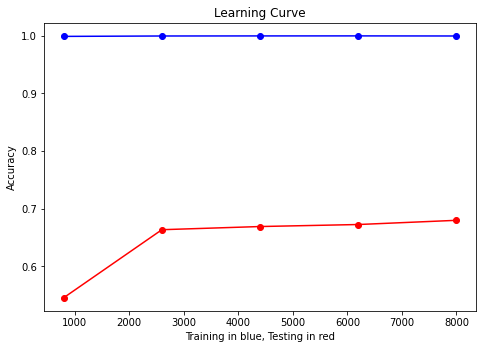

PRINTING METRICS FOR XGBoost/TFIDF


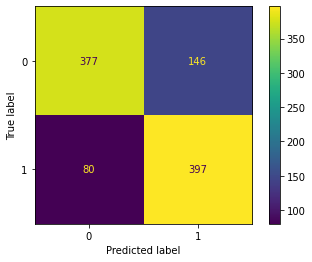

ROC/AUC for each class: 

{0: 0.7765632077475939, 1: 0.7765632077475939}


Classification Report = 
                precision    recall  f1-score   support

           0       0.82      0.72      0.77       523
           1       0.73      0.83      0.78       477

    accuracy                           0.77      1000
   macro avg       0.78      0.78      0.77      1000
weighted avg       0.78      0.77      0.77      1000



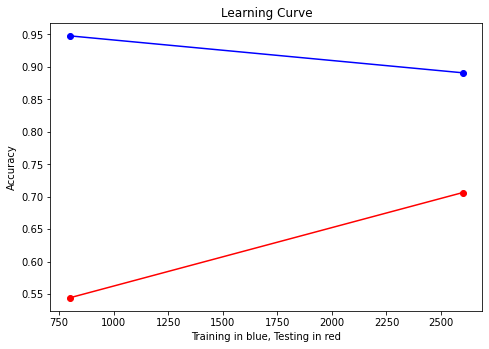

PRINTING METRICS FOR XGBoost/FastText


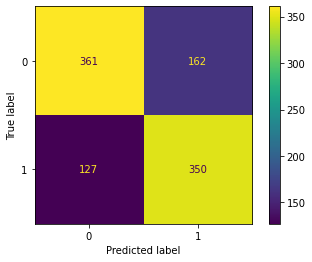

ROC/AUC for each class: 

{0: 0.7120005932553284, 1: 0.7120005932553284}


Classification Report = 
                precision    recall  f1-score   support

           0       0.74      0.69      0.71       523
           1       0.68      0.73      0.71       477

    accuracy                           0.71      1000
   macro avg       0.71      0.71      0.71      1000
weighted avg       0.71      0.71      0.71      1000



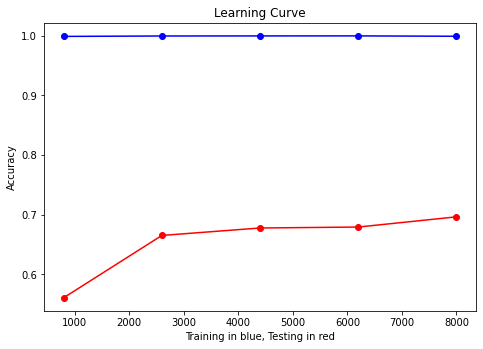

In [56]:
if PRINT_METRICS:
    show_metrics('XGBoost/Word2Vec',all_models[3]['xgb_clf_w2v'],validation_set_w2v,validation_labels_w2v,all_models[3]['xgb_clf_w2v_preds'],X_W2V,y,5)
    show_metrics('XGBoost/TFIDF',all_models[3]['xgb_clf_tfidf'],validation_set_tfidf,validation_labels_tfidf,all_models[3]['xgb_clf_tfidf_preds'],\
                np.concatenate([train_set_tfidf,validation_set_tfidf,test_set_tfidf]),y,5)
    show_metrics('XGBoost/FastText',all_models[3]['xgb_clf_ft'],validation_set_ft,validation_labels_ft,all_models[3]['xgb_clf_ft_preds'],X_FT,y,5)